# Astroquery Tutorial
Astroquery is a module of astropy that provides a set of tools to query astronomical databases. In this tutorial, we will focus on the CADC package of astroquery, which queries data provided by the Canadian Astronomical Data Centre.

- https://github.com/astropy/astroquery

Resources:

- http://www.cadc-ccda.hia-iha.nrc-cnrc.gc.ca/en/doc/tap/
- https://www.cadc-ccda.hia-iha.nrc-cnrc.gc.ca/en/search/
- https://www.cadc-ccda.hia-iha.nrc-cnrc.gc.ca/data/
- http://www.canfar.net/storage/list/CADC

The first step is to import the CADC module from astroquery.

In [1]:
import numpy as np

# Set up matplotlib and use a nicer set of plot parameters
%config InlineBackend.rc = {}
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline


In [2]:
from astroquery.cadc import Cadc
cadc = Cadc()


There are three ways to query the data - target the region, the name of the object, or use TAP to query the database.

### Query by region

Perhaps we want to query by region, we can input the postition in ICRS (international celestial reference system) and specify the collection - in this case, the Canada France Hawaii Telescope. or CFHT.

In [3]:
from astropy.coordinates import SkyCoord
from astropy import units as u

# First we pick some coordinates that we want to query around
# Check out http://docs.astropy.org/en/stable/coordinates/index.html for more info on coordinates
c = SkyCoord(ra=127.5*u.degree, dec=4.3*u.degree, frame='icrs')
c = SkyCoord('08h30m00s', '+04d18m00s', frame='icrs')
# These coordinates are equivalent!

# Then we choose a radius in degrees
r = 0.5

print('Coordinates: ', c)
print('Radius: ', r)

Coordinates:  <SkyCoord (ICRS): (ra, dec) in deg
    (127.5, 4.3)>
Radius:  0.5


In [4]:
# Now we can run the query
# PROBLEM: query_region does not accept `astropy.units.Quantity` as in the docs.
result = cadc.query_region(c, radius=r, collection='HST')
len(result)

75

Lets filter down the results a little more. Lets look through the columns to see which information we want to look at to make things simpler.

http://docs.astropy.org/en/stable/table/


In [9]:
# result.info
#[print(col.info) for col in result.columns.values()]; 
[print(colname) for colname in result.colnames];

caomObservationURI
sequenceNumber
proposal_keywords
target_standard
target_redshift
target_moving
target_keywords
targetPosition_equinox
targetPosition_coordinates_cval1
targetPosition_coordinates_cval2
telescope_geoLocationX
telescope_geoLocationY
telescope_geoLocationZ
telescope_keywords
instrument_keywords
environment_seeing
environment_humidity
environment_elevation
environment_tau
environment_wavelengthTau
environment_ambientTemp
environment_photometric
members
typeCode
metaChecksum
obsID
accMetaChecksum
collection
observationID
algorithm_name
type
intent
metaRelease
proposal_id
proposal_pi
proposal_project
proposal_title
target_name
target_type
targetPosition_coordsys
telescope_name
requirements_flag
instrument_name
lastModified
maxLastModified
caomPlaneURI
caomPublisherID
calibrationLevel
provenance_keywords
provenance_inputs
metrics_sourceNumberDensity
metrics_background
metrics_backgroundStddev
metrics_fluxDensityLimit
metrics_magLimit
position_bounds
position_bounds_samples
p

Alright, lets look at `caomObservationURI`, `typeCode`, `type`, `intent`, `target_name`, `telescope_name`, `instrument_name`, and `lastModified`. We can grab information about the columns using the `info` property.

In [13]:
result['caomObservationURI', 'typeCode', 'type', 'intent', 'target_name', 
       'telescope_name', 'instrument_name', 'lastModified'].info


<Table masked=True length=75>
       name         dtype                                      description                                    
------------------ ------- -----------------------------------------------------------------------------------
caomObservationURI  object                                                     unique URI for this observation
          typeCode  bytes1 single character code to denote type: S(impleObservation) or C(ompositeOvservation)
              type bytes32                                   type of data collected (e.g. FITS OBSTYPE header)
            intent bytes32                             intended purpose of data (one of: science, calibration)
       target_name bytes32                                                             name of intended target
    telescope_name bytes32                                       name of telescope used to acquire observation
   instrument_name bytes32                                      name of instrument

We can also print out the results in a nice table using `show_in_notebook`.

In [18]:
columns_to_print = ['caomObservationURI', 'typeCode', 'type', 'intent', 'target_name', 
       'telescope_name', 'instrument_name', 'lastModified']
result[columns_to_print].show_in_notebook()


idx,caomObservationURI,typeCode,type,intent,target_name,telescope_name,instrument_name,lastModified
0,caom:HST/jdooeay2q,S,INTERNAL,calibration,DARK,HST,ACS/WFC,2018-11-01T17:07:42.176
1,caom:HST/jdooeay2q,S,INTERNAL,calibration,DARK,HST,ACS/WFC,2018-11-01T17:07:42.176
2,caom:HST/odpkigxqq,S,IMAGING,calibration,DARK,HST,STIS/CCD,2018-10-28T16:51:33.462
3,caom:HST/odpkigxqq,S,IMAGING,calibration,DARK,HST,STIS/CCD,2018-10-28T16:51:33.462
4,caom:HST/odpkigxpq,S,IMAGING,calibration,DARK,HST,STIS/CCD,2018-10-28T16:51:55.473
5,caom:HST/odpkigxpq,S,IMAGING,calibration,DARK,HST,STIS/CCD,2018-10-28T16:51:55.473
6,caom:HST/jdooeay1q,S,INTERNAL,calibration,BIAS,HST,ACS/WFC,2018-09-29T13:48:41.207
7,caom:HST/jdooeay1q,S,INTERNAL,calibration,BIAS,HST,ACS/WFC,2018-09-29T13:48:41.207
8,caom:HST/idoe58y7q,S,IMAGING,calibration,DARK-EARTH-CALIB,HST,WFC3/IR,2018-09-29T13:48:41.455
9,caom:HST/idoe58y7q,S,IMAGING,calibration,DARK-EARTH-CALIB,HST,WFC3/IR,2018-09-29T13:48:41.455


So now we have a list of observations that satisfy our inital query, as well as some information about the observation.

Lets filter out the results such that `type` is IMAGING and `intent` is science

In [17]:
filter_mask = ((result['type'] == 'IMAGING') & (result['intent'] == 'science'))
filtered_results = result[filter_mask]
print(len(filtered_results))


36


Now we have narrowed down our results. To download the data, the `get_data_urls` function is called.

In [16]:
urls = cadc.get_data_urls(filtered_results)
[print(url) for url in urls];

https://www.cadc-ccda.hia-iha.nrc-cnrc.gc.ca/data/pub/MAST/HST/product/idns10xtq_flc.fits?RUNID=pqtpugd8wjevsrak
https://www.cadc-ccda.hia-iha.nrc-cnrc.gc.ca/data/pub/MAST/HST/product/idns10xtq_flt.fits?RUNID=pqtpugd8wjevsrak
https://www.cadc-ccda.hia-iha.nrc-cnrc.gc.ca/data/pub/MAST/HST/product/idns10xtq_drz.fits?RUNID=nccxa3f4auk3v7e1
https://www.cadc-ccda.hia-iha.nrc-cnrc.gc.ca/data/pub/MAST/HST/product/idns10xtq_drc.fits?RUNID=nccxa3f4auk3v7e1
https://www.cadc-ccda.hia-iha.nrc-cnrc.gc.ca/data/pub/MAST/HST/product/idns10xtq_raw.fits?RUNID=uc31tinkzvcalf36
https://www.cadc-ccda.hia-iha.nrc-cnrc.gc.ca/data/pub/MAST/HST/product/idns10010_drc.fits?RUNID=awx8iycexm3ijxpu
https://www.cadc-ccda.hia-iha.nrc-cnrc.gc.ca/data/pub/MAST/HST/product/idns10010_drz.fits?RUNID=awx8iycexm3ijxpu
https://www.cadc-ccda.hia-iha.nrc-cnrc.gc.ca/data/pub/MAST/HST/product/idns10xzq_flc.fits?RUNID=aky5upldn7opdzck
https://www.cadc-ccda.hia-iha.nrc-cnrc.gc.ca/data/pub/MAST/HST/product/idns10xzq_flt.fits?RUNID=

Clicking on a url will start downloading the observation data.

Alternatively, an astropy package can open the file..

In [21]:
from astropy.io import fits

with fits.open(urls[0]) as hdu_file:
    hdu_file.info()
    image_data = hdu_file[1].data

Filename: /home/badune/.astropy/cache/download/py3/1c49047f7c1cffa94575c194f6b558db
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU     305   ()      
  1  SCI           1 ImageHDU       175   (4096, 2051)   float32   
  2  ERR           1 ImageHDU        51   (4096, 2051)   float32   
  3  DQ            1 ImageHDU        43   (4096, 2051)   int16   
  4  SCI           2 ImageHDU       173   (4096, 2051)   float32   
  5  ERR           2 ImageHDU        51   (4096, 2051)   float32   
  6  DQ            2 ImageHDU        43   (4096, 2051)   int16   
  7  D2IMARR       1 ImageHDU        15   (64, 32)   float32   
  8  D2IMARR       2 ImageHDU        15   (64, 32)   float32   
  9  D2IMARR       3 ImageHDU        15   (64, 32)   float32   
 10  D2IMARR       4 ImageHDU        15   (64, 32)   float32   
 11  WCSDVARR      1 ImageHDU        15   (64, 32)   float32   
 12  WCSDVARR      2 ImageHDU        15   (64, 32)   float32   
 13  WCSDVARR  

In [38]:
print(type(image_data))
print(image_data.shape)

<class 'numpy.ndarray'>
(2051, 4096)


In [41]:
print('Min:', np.min(image_data))
print('Max:', np.max(image_data))
print('Mean:', np.mean(image_data))
print('Stdev:', np.std(image_data))

Min: -645.275
Max: 73330.28
Mean: 17.466717
Stdev: 351.1627


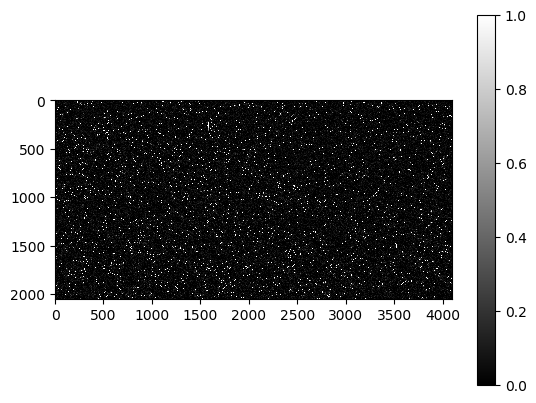

In [48]:
from astropy.visualization import ImageNormalize
normalized_image_data = ImageNormalize(vmin=0, vmax=100)(image_data)

plt.imshow(normalized_image_data, cmap='gray')
plt.colorbar()


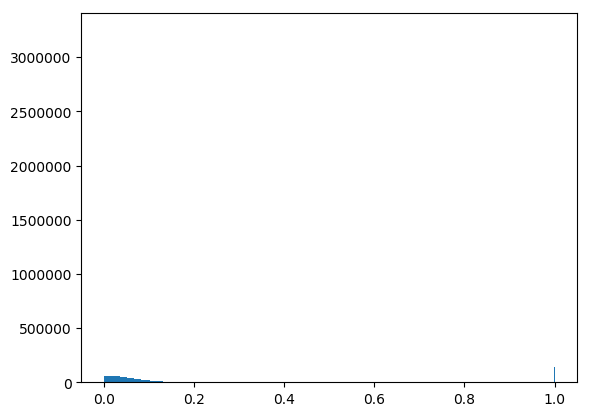

In [49]:
NBINS = 1000
histogram = plt.hist(normalized_image_data.flatten(), NBINS)

https://astroquery.readthedocs.io/en/latest/gallery.html#example-10

### Query by object

Lets say we want to get data about the Andromeda Galaxy. It is also know as Messier 31, and therefore has identifier `M31`. We would use the `query_name` function to retreive data that contains 'M31' in an observation's `target_name`

In [66]:
result = cadc.query_name('M31')


In [67]:
len(result)

2000

So 2000 is actually the maximum number of results that a synchronous call will make, so there is reason to suspect that there are more results to this query not being shown. In order to make asynchronous calls, we need to use TAP to access the CADC database. TAP stands for transfer access protocol and is a standardized 

### Query using TAP
You can query tap with or without authentication. You need authentication to access TAP+ capabilities (share tables, persistent jobs, etc.), but we will get to that later.

First, let's take a look at how the database is organized and print the names of all the tables.


In [75]:
tables = cadc.get_tables()

[print(table.get_qualified_name()) for table in tables];

Retrieving tables...
Parsing tables...
Done.
caom2.caom2.Observation
caom2.caom2.Plane
caom2.caom2.Artifact
caom2.caom2.Part
caom2.caom2.Chunk
caom2.caom2.ObservationMember
caom2.caom2.ProvenanceInput
caom2.caom2.EnumField
caom2.caom2.ObsCoreEnumField
caom2.caom2.distinct_proposal_id
caom2.caom2.distinct_proposal_pi
caom2.caom2.distinct_proposal_title
caom2.caom2.HarvestSkipURI
caom2.caom2.SIAv1
ivoa.ivoa.ObsCore
ivoa.ivoa.ObsFile
ivoa.ivoa.ObsPart
tap_schema.tap_schema.schemas
tap_schema.tap_schema.tables
tap_schema.tap_schema.columns
tap_schema.tap_schema.keys
tap_schema.tap_schema.key_columns


In [161]:
# To fetch a single table object

table = cadc.get_table(table='caom2.caom2.Observation')

[print(col.name) for col in table.columns];

Retrieving tables...
Parsing tables...
Done.
observationURI
obsID
collection
observationID
algorithm_name
type
intent
sequenceNumber
metaRelease
proposal_id
proposal_pi
proposal_project
proposal_title
proposal_keywords
target_name
target_type
target_standard
target_redshift
target_moving
target_keywords
targetPosition_coordinates_cval1
targetPosition_coordinates_cval2
targetPosition_coordsys
targetPosition_equinox
telescope_name
telescope_geoLocationX
telescope_geoLocationY
telescope_geoLocationZ
telescope_keywords
requirements_flag
instrument_name
instrument_keywords
environment_seeing
environment_humidity
environment_elevation
environment_tau
environment_wavelengthTau
environment_ambientTemp
environment_photometric
members
typeCode
lastModified
maxLastModified
metaChecksum
accMetaChecksum


#### Running a synchronous query
A synchronous query has a limit of 2000 rows, so these are suited to queries that are smaller. Results can be saved in memory or a file. We use ADQL to specify the query (http://www.ivoa.net/documents/ADQL/2.0). Using ADQL, we SELECT the columns we want FROM one or multiple tables WHERE a condition is met.

For example, say we want to look at the observationID, intent, and target_name columns from the observation table, then we would run the following (limited to 2000 results)...

In [100]:
query = "SELECT observationID, intent, target_name FROM caom2.Observation"
job = cadc.run_query(query, 'sync')
results = job.get_results()

Lets make a histogram of target_names!

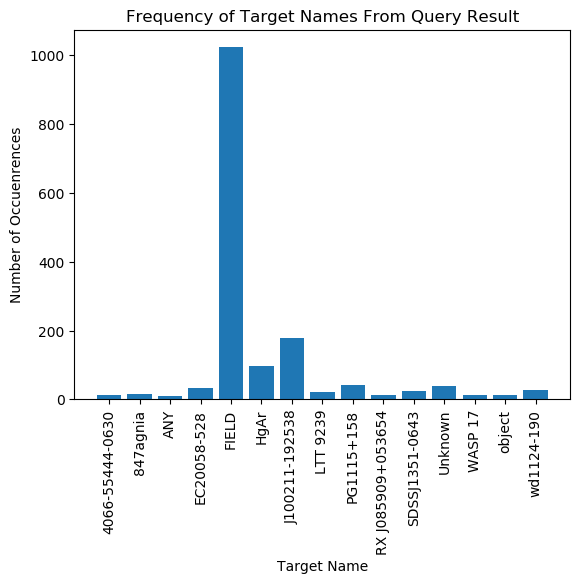

In [158]:
target_names, counts = np.unique(results['target_name'], return_counts=True)

# Remove all counts of less than 5 - otherwise too much data
mask = counts >=10
filtered_target_names = target_names[mask]
filtered_counts = counts[mask]

indices = np.arange(len(filtered_target_names))
plt.bar(indices, filtered_counts)
plt.title('Frequency of Target Names From Query Result')
plt.ylabel('Number of Occuenrences')
plt.xlabel('Target Name')
plt.xticks(range(len(filtered_target_names)), labels=filtered_target_names, rotation='vertical');

So the most common target name by far is `FIELD`.

We can also save results from a query to a file. Now lets select the observation ID, instrumnent name, and image position bounds from the observation and plane data tables, where the instrument is the SCUBA-2 telescope.

In [178]:
query = "SELECT Observation.observationID, Observation.instrument_name, Plane.position_bounds " + \
    "FROM caom2.Plane AS Plane JOIN caom2.Observation AS Observation ON Plane.obsID = Observation.obsID " + \
    "WHERE Observation.instrument_name = 'SCUBA-2'"
cadc.run_query(query, 'sync', output_file='test_output_noauth.tsv', output_format='tsv')


Additionally, a table can be uploaded to the server to be used in a query

In [ ]:
upload_resource = 'data/votable.xml'
j = cadc.run_query("SELECT * FROM tap_upload.test_table_upload", 'sync', \
                  upload_resource=upload_resource, upload_table_name="test_table_upload")

print(j.get_results())


### Asyncronous query
 Asynchronous queries results at server side. The queries can be accessed any time. As with synchronous queries, the results can be saved in memory (default) or in a file.

In [52]:
query = "SELECT observationID, instrument_name, target_name FROM caom2.Observation AS Observation"
job = cadc.run_query(query, 'async', verbose=True)
print(job)

Launched query: 'SELECT observationID, instrument_name, target_name FROM caom2.Observation AS Observation'
303 See Other
[('Date', 'Thu, 09 May 2019 16:25:56 GMT'), ('Strict-Transport-Security', 'max-age=0'), ('Location', 'https://www.cadc-ccda.hia-iha.nrc-cnrc.gc.ca/tap//async/m9rkat6qbm6hw0bb'), ('Content-Length', '0'), ('Vary', 'Origin'), ('Connection', 'close'), ('Content-Type', 'text/plain')]
303 See Other
[('Date', 'Thu, 09 May 2019 16:25:56 GMT'), ('Strict-Transport-Security', 'max-age=0'), ('Location', 'https://www.cadc-ccda.hia-iha.nrc-cnrc.gc.ca/tap//async/m9rkat6qbm6hw0bb'), ('Content-Length', '0'), ('Vary', 'Origin'), ('Connection', 'close'), ('Content-Type', 'text/plain')]
job m9rkat6qbm6hw0bb, at: https://www.cadc-ccda.hia-iha.nrc-cnrc.gc.ca/tap//async/m9rkat6qbm6hw0bb


Exception: Not Found

In [53]:
async_result = cadc.query_name_async('M31') # Not actually async?

TypeError: query_name_async() got an unexpected keyword argument 'verbose'

In [51]:
async_result.get_results()['caomObservationURI', 'target_name', 'target_type']

caomObservationURI,target_name,target_type
object,bytes32,bytes32
caom:HSTHLA/hst_12106_06_wfc3_ir_f160w_02,M31-B16-F06-IR,
caom:HSTHLA/hst_12073_10_wfc3_ir_f160w_04,M31-B02-F10-IR,
caom:CFHT/548630,m31,
caom:CFHT/548631,m31,
caom:CFHT/876828,M31-N,
caom:CFHT/876828,M31-N,
caom:CFHT/876828,M31-N,
caom:CFHT/548629,m31,
caom:CFHT/548637,m31,
